# Looped

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
from pathlib import Path
sys.path.append(str(Path('..') / 'src'))

import numpy as np
import matplotlib.pyplot as plt

from config import PhysicsConfig, SpikingRadarConfig, ObjectsConfig
from transmitter import SpikingRadarTx, SpikingRadarTransmitter, SingleSpikeTransmitter
from environment import SpikingRadarChannel_1D
from receiver import SpikingRadarRx, SpikingRadarReceiver_1D
from models.spiking_radar import SpikingRadarCorrelator
from models.spiking_lif_delay import SpikingLIFDelayEstimator
from output import SpikingRadarResult_1D



In [3]:
# Setup and config

physics_config = PhysicsConfig(wave_type="sound")
model_config = SpikingRadarConfig(
    fs_hz=100_000.0,
    duration_s=0.1,
    spike_prob_per_ms=0.1,
    chirp_duration_s=0.005,
    chirp_bandwidth_hz=5_000.0,
    chirp_start_hz=1_000.0,
    carrier_hz=20_000.0,
    attenuation=0.5,
    noise_std=0.1,
    threshold=0.5,
    lowpass_cutoff_hz=20_000.0,
)

tau_ms = 5/model_config.fs_hz # 5 samples

transmitter = SpikingRadarTransmitter(model_config)
receiver = SpikingRadarReceiver_1D(model_config)
processing_model = SpikingLIFDelayEstimator(
    model_config,
    physics_config,
    max_delay_s=0.1,        # search window
    tau_m_s=tau_ms,          # coincidence window (~5 samples)
    w_tx=1.0,
    w_rx=1.0,
    v_th=1.5,
)



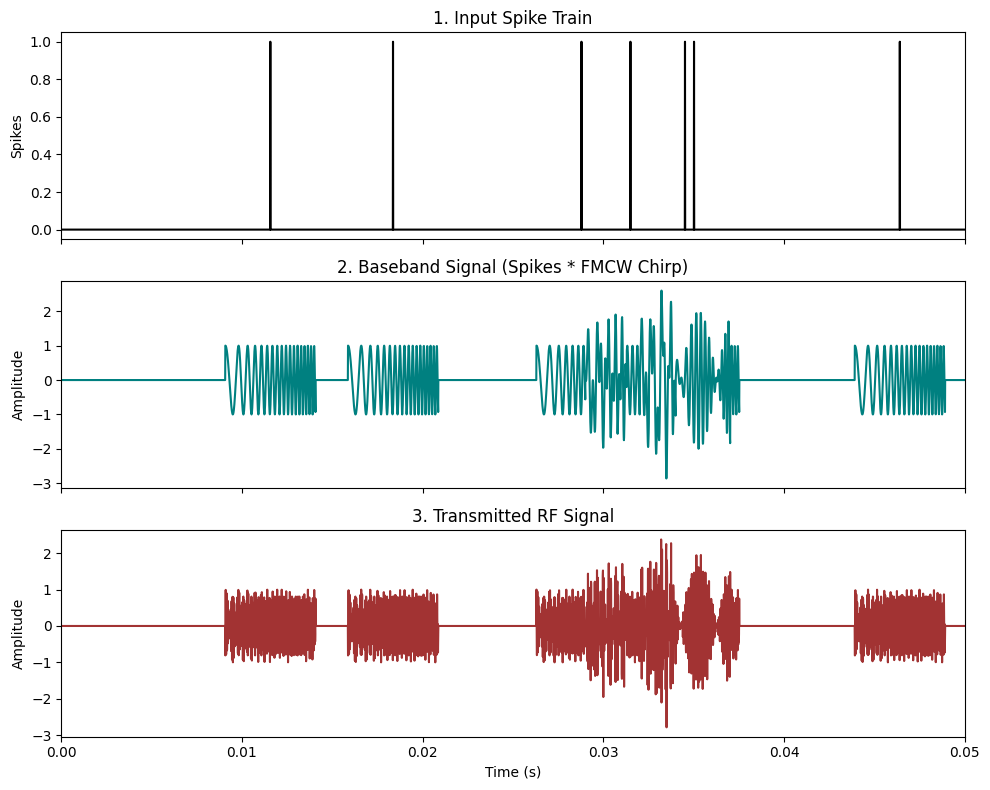

(<Figure size 1000x800 with 3 Axes>,
 array([<Axes: title={'center': '1. Input Spike Train'}, ylabel='Spikes'>,
        <Axes: title={'center': '2. Baseband Signal (Spikes * FMCW Chirp)'}, ylabel='Amplitude'>,
        <Axes: title={'center': '3. Transmitted RF Signal'}, xlabel='Time (s)', ylabel='Amplitude'>],
       dtype=object))

In [4]:
# transmitter

tx = transmitter.build()
transmitter.plot(tx)


In [10]:
distances = np.linspace(0, 10, 100)
distances_measured = []

for d in distances:
    # Config
    objects = ObjectsConfig(object_location_1D = d)
    environment = SpikingRadarChannel_1D(model_config, physics_config, objects)
    # Environment
    rx_signal = environment.propagate(tx.tx_signal)

    # Receiver

    demod_raw = receiver.demodulate(rx_signal, tx.time_s)
    rx_baseband = receiver.lowpass(demod_raw)
    recovered_signal = receiver.matched_filter(rx_baseband, tx.chirp_template)
    recovered_spikes = receiver.recover_spikes(recovered_signal)

    rx = SpikingRadarRx(
        rx_signal=rx_signal,
        rx_baseband=rx_baseband,
        recovered_signal=recovered_signal,
        recovered_spikes=recovered_spikes,
    )
    #receiver.plot(tx.time_s, tx.tx_signal, rx)

    #plt.plot(rx.recovered_spikes)
    #plt.title("Recovered spikes fed to SNN")

    # Processing unit
    result = processing_model.estimate(
        tx.spikes,
        rx.recovered_spikes,
    )
    #print(result)

    #processing_model.plot(result)

    distance_est = result.distance_m
    delay_s = result.delay_s
    distances_measured.append(distance_est)






RMSE: 0.0036 m
MAE:  0.0036 m


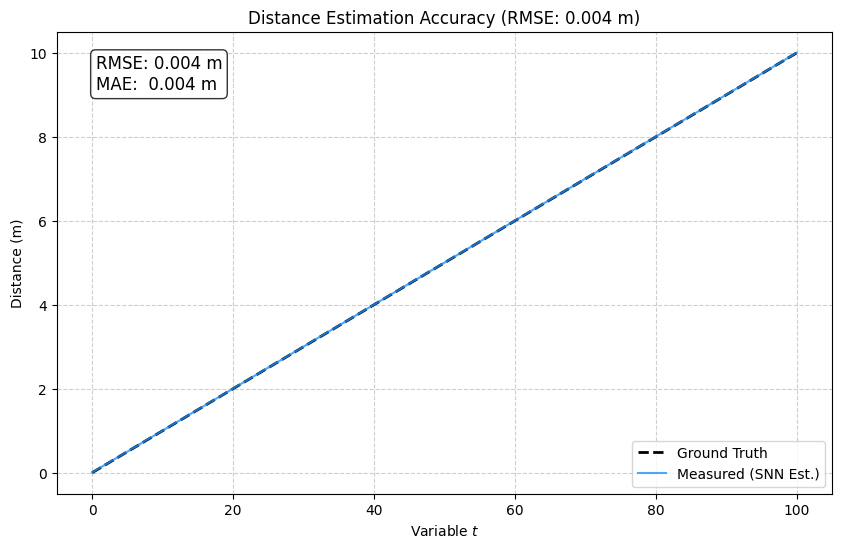

In [ ]:
# 1. Setup Data
# Ensure we are working with numpy arrays for the math
d_actual = np.array(distances)
d_measured = np.array(distances_measured)

# Create arbitrary variable t
t = np.linspace(0, 100, len(d_actual))

# 2. Calculate RMSE (Root Mean Square Error)
# Formula: sqrt(mean(error^2))
error = d_measured - d_actual
mse = np.mean(error ** 2)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE) for context - optional but helpful
mae = np.mean(np.abs(error))

print(f"RMSE: {rmse:.4f} m")
print(f"MAE:  {mae:.4f} m")

# 3. Plot with Metrics
plt.figure(figsize=(10, 6))

# Plot Actual vs Measured
plt.plot(t, d_actual, label='Ground Truth', color='black', linestyle='--', linewidth=2)
plt.plot(t, d_measured, label='Measured (SNN Est.)', color='dodgerblue', alpha=0.8)

# Add text box for statistics
stats_text = f'RMSE: {rmse:.3f} m\nMAE:  {mae:.3f} m'
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title(f'Distance Estimation Accuracy')
plt.xlabel('Variable $t$')
plt.ylabel('Distance (m)')
plt.legend(loc='lower right')
plt.grid(True, which='both', linestyle='--', alpha=0.6)

plt.show()

/var/folders/9m/5yl447m538l3dw65wfhnx6xh0000gn/T/ipykernel_18718/884563176.py:5: RuntimeWarning: divide by zero encountered in divide
  error = (distances_measured_arr - distances)*100/distances


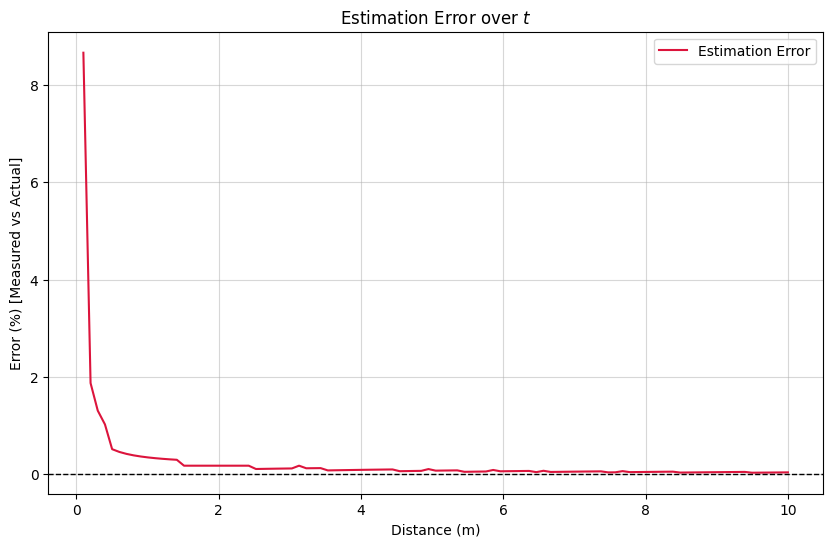

In [9]:
# Convert list to array
distances_measured_arr = np.array(distances_measured)

# Calculate Error
error = (distances_measured_arr - distances)*100/distances

plt.figure(figsize=(10, 6))

# Plot the error
plt.plot(distances, error, color='crimson', label='Estimation Error')
# Add a zero line for reference
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Estimation Error over $t$')
plt.xlabel('Distance (m)')
plt.ylabel('Error (%) [Measured vs Actual]')
plt.grid(True, alpha=0.5)
plt.legend()

plt.show()

RMSE: 0.0036 m
MAE:  0.0036 m


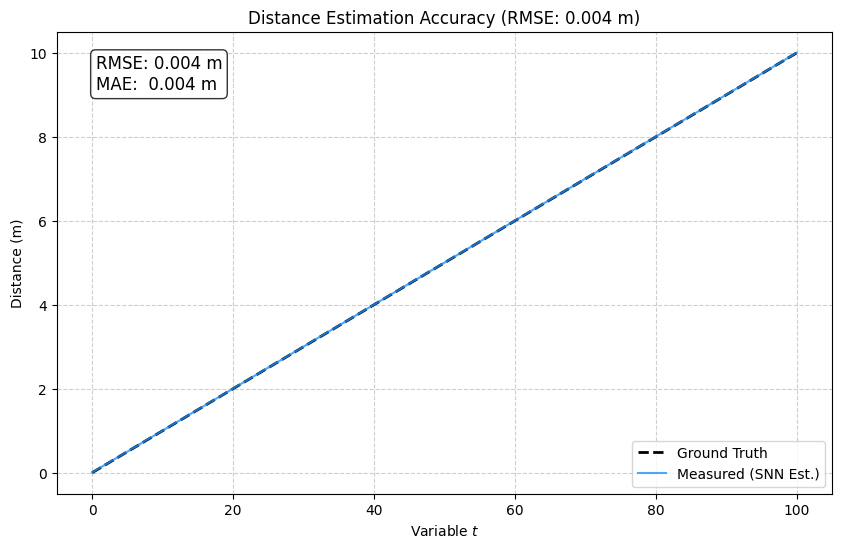

In [11]:
# 1. Setup Data
# Ensure we are working with numpy arrays for the math
d_actual = np.array(distances)
d_measured = np.array(distances_measured)

# Create arbitrary variable t
t = np.linspace(0, 100, len(d_actual))

# 2. Calculate RMSE (Root Mean Square Error)
# Formula: sqrt(mean(error^2))
error = d_measured - d_actual
mse = np.mean(error ** 2)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE) for context - optional but helpful
mae = np.mean(np.abs(error))

print(f"RMSE: {rmse:.4f} m")
print(f"MAE:  {mae:.4f} m")

# 3. Plot with Metrics
plt.figure(figsize=(10, 6))

# Plot Actual vs Measured
plt.plot(t, d_actual, label='Ground Truth', color='black', linestyle='--', linewidth=2)
plt.plot(t, d_measured, label='Measured (SNN Est.)', color='dodgerblue', alpha=0.8)

# Add text box for statistics
stats_text = f'RMSE: {rmse:.3f} m\nMAE:  {mae:.3f} m'
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title(f'Distance Estimation Accuracy (RMSE: {rmse:.3f} m)')
plt.xlabel('Variable $t$')
plt.ylabel('Distance (m)')
plt.legend(loc='lower right')
plt.grid(True, which='both', linestyle='--', alpha=0.6)

plt.show()

-----